# Y.Afisha: Ayuda a optimizar los gastos de marketing

# Descripción del Proyecto

Se te ha ido muy bien en el curso TripleTen y te han ofrecido hacer prácticas en el departamento analítico de Y.Afisha. Tu primera tarea es ayudar a optimizar los gastos de marketing.

* Lo que tienes:
registros del servidor con datos sobre las visitas a Y.Afisha desde junio de 2017 hasta mayo de 2018;
un archivo con los pedidos en este periodo;
estadísticas de gastos de marketing.

* Lo que vas a investigar:
cómo los clientes usan el servicio;
cuándo empiezan a comprar;
cuánto dinero aporta cada cliente a la compañía;
cuándo los ingresos cubren el costo de adquisición de los clientes.


# Descripción de datos

La tabla visits (registros del servidor con datos sobre las visitas al sitio web):
* Uid: identificador único del usuario;
* Device: dispositivo del usuario;
* Start Ts: fecha y hora de inicio de la sesión;
* End Ts: fecha y hora de término de la sesión;
* Source Id: identificador de la fuente de anuncios de la que proviene el usuario.
Todas las fechas de esta tabla están en formato AAAA-MM-DD.

La tabla orders (datos sobre pedidos):
* Uid: identificador único del usuario que realiza un pedido;
* Buy Ts: fecha y hora del pedido;
* Revenue: ingresos de Y.Afisha de este pedido.

La tabla costs (datos sobre gastos de marketing):
* source_id: identificador de la fuente de anuncios
* dt: fecha;
* costs: gastos en esta fuente de anuncios en este día.


## Preparación y Análisis de datos

### Importación de librerías

In [1]:
# Importamos librerías que se usarán en el proyecto
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

### Importación de datos preliminar

In [2]:
# Importamos los archivos de datos

visits = pd.read_csv('/datasets/visits_log_us.csv', nrows = 500)
orders = pd.read_csv('/datasets/orders_log_us.csv', nrows = 500)
costs = pd.read_csv('/datasets/costs_us.csv', nrows = 500)

### Análisis de cada dataframe

#### Dataframe "visits"

In [3]:
# descripción general del dataframe "visits"
visits.info(memory_usage = 'deep')

print(visits.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB
    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  


In [4]:
# Cambiamos los nombres de las columnas para respetar el estilo snake_case
columns_visits = {'Device':'device', 'End Ts':'end_ts', 'Source Id':'source_id', 'Start Ts':'start_ts', 'Uid':'uid'}

visits.rename(columns = columns_visits, inplace = True) 

In [5]:
# Cambiamos el tipo de datos de la columna "end_ts" y "start_ts"
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [6]:
# Validamos si el campo "device" puede cambiarse el tipo de dato a category
visits['device'].value_counts()

visits['device'] = visits['device'].astype('category')

In [7]:
# Validamos si se redujo el peso de uso en memoria del dataframe
visits.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   device     500 non-null    category      
 1   end_ts     500 non-null    datetime64[ns]
 2   source_id  500 non-null    int64         
 3   start_ts   500 non-null    datetime64[ns]
 4   uid        500 non-null    uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 16.5 KB


Luego de analizar el dataframe, se identifico lo siguiente:
* Los nombres de las columnas no se encontraban estandarizados, se debe considerar usar el estilo snake_case para una mejor manipulación de datos.
* Los campos "end_ts" y "start_ts" se cargarán con el tipo de dato datetime para optimizar la carga de datos.
* El campo "device" se cargará como tipo de dato category para optimizar la carga de datos.

#### Dataframe "orders"

In [8]:
# descripción general del dataframe "orders"
orders.info(memory_usage = 'deep')

print(orders.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   500 non-null    object 
 1   Revenue  500 non-null    float64
 2   Uid      500 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 45.0 KB
                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450


In [9]:
# Cambiamos los nombres de las columnas para respetar el estilo snake_case
columns_orders = {'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'}

#Ejecutaremos el cambio al momento de cargar la información considerando la optimización de datos
orders.rename(columns = columns_orders, inplace = True) 

In [10]:
# Cambiamos el tipo de dato de la columna "buy_ts"
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [11]:
# Validamos si se redujo el peso de uso en memoria del dataframe
orders.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   500 non-null    datetime64[ns]
 1   revenue  500 non-null    float64       
 2   uid      500 non-null    uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 11.8 KB


Luego de analizar el dataframe, se identifico lo siguiente:
* Los nombres de las columnas no se encontraban estandarizados, se consideró usar el estilo snake_case para una mejor manipulación de datos.
* El campo "buy_ts" se cargará con el tipo de dato datetime para optimizar la carga de datos.

#### Dataframe "costs"

In [12]:
# descripción general del dataframe "costs"
costs.info(memory_usage = 'deep')

print(costs.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  500 non-null    int64  
 1   dt         500 non-null    object 
 2   costs      500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 40.7 KB
   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08


In [13]:
# Cambiamos el tipo de dato de la columna "dt"
costs['dt'] = pd.to_datetime(costs['dt'])

In [14]:
# Validamos si se redujo el peso de uso en memoria del dataframe
costs.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  500 non-null    int64         
 1   dt         500 non-null    datetime64[ns]
 2   costs      500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


Luego de analizar el dataframe, se identifico lo siguiente:
* El campo "dt" se cargará con el tipo de dato datetime para optimizar la carga de datos.

### Carga de datos optimizada
Considerando la evaluación que se realizó en el punto 1.3 para cada dataframe, realizamos la importación de datos optimizada y corregimos el nombre de columnas para algunos dataframes.

In [15]:
# dataframe "visits"
visits = pd.read_csv(
    '/datasets/visits_log_us.csv',
    #nrows=500,
    dtype={'Device': 'category'},
    parse_dates=['Start Ts', 'End Ts'],
)

visits.rename(columns = columns_visits, inplace = True)

print(visits.info(memory_usage = 'deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
None


In [16]:
# dataframe "orders"
orders = pd.read_csv(
    '/datasets/orders_log_us.csv',
    #nrows=500,
    parse_dates=['Buy Ts'],
)

orders.rename(columns = columns_orders, inplace = True)

print(orders.info(memory_usage = 'deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None


In [17]:
# dataframe "costs"
costs = pd.read_csv(
    '/datasets/costs_us.csv',
    #nrows=500,
    parse_dates=['dt']
)

print(costs.info(memory_usage = 'deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
None


### Validación de registros duplicados

In [18]:
print('# Registros duplicados en el dataframe Visits:', visits.duplicated().sum())
print('# Registros duplicados en el dataframe Orders:', orders.duplicated().sum())
print('# Registros duplicados en el dataframe Costs:', costs.duplicated().sum())

# Registros duplicados en el dataframe Visits: 0
# Registros duplicados en el dataframe Orders: 0
# Registros duplicados en el dataframe Costs: 0


Validamos que no existen registros duplicados.

## Informes  y cálculo de métricas

### Visitas

#### ¿Cuántas personas lo usan cada día, semana y mes?

In [19]:
# Creamos las columnas que requeriremos para hallar los indicadores de DAU, WAU y MAU
visits['session_date'] = visits['start_ts'].dt.strftime('%Y-%m-%d')
visits['session_week'] = visits['start_ts'].dt.week
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month

visits['session_week_YYYYWW'] = visits['session_year']*100 + visits['session_week']
visits['session_month_YYYYMM'] = visits['start_ts'].dt.strftime('%Y-%m')

print(visits.head(5))

# Agrupamos las columnas para hallar los indicadores
sessions_per_day = visits.groupby('session_date').agg({'uid':['nunique','count']}).reset_index()
sessions_per_week = visits.groupby('session_week_YYYYWW').agg({'uid':['nunique','count']}).reset_index()
sessions_per_month = visits.groupby('session_month_YYYYMM').agg({'uid':['nunique','count']}).reset_index()

# Renombramos las columnas
sessions_per_day.columns = ['session_date','n_users','n_sessions']
sessions_per_week.columns = ['session_week','n_users', 'n_sessions']
sessions_per_month.columns = ['session_month','n_users','n_sessions']

#print(visits.info(memory_usage = 'deep'))

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid session_date  session_week  session_year  \
0  16879256277535980062   2017-12-20            51          2017   
1    104060357244891740   2018-02-19             8          2018   
2   7459035603376831527   2017-07-01            26          2017   
3  16174680259334210214   2018-05-20            20          2018   
4   9969694820036681168   2017-12-27            52          2017   

   session_month  session_week_YYYYWW session_month_YYYYMM  
0             12               201751              2017-12  
1              2               201808              2018-02  
2              7 

# Promedio de personas que usan la app por día: 907.9917582417582


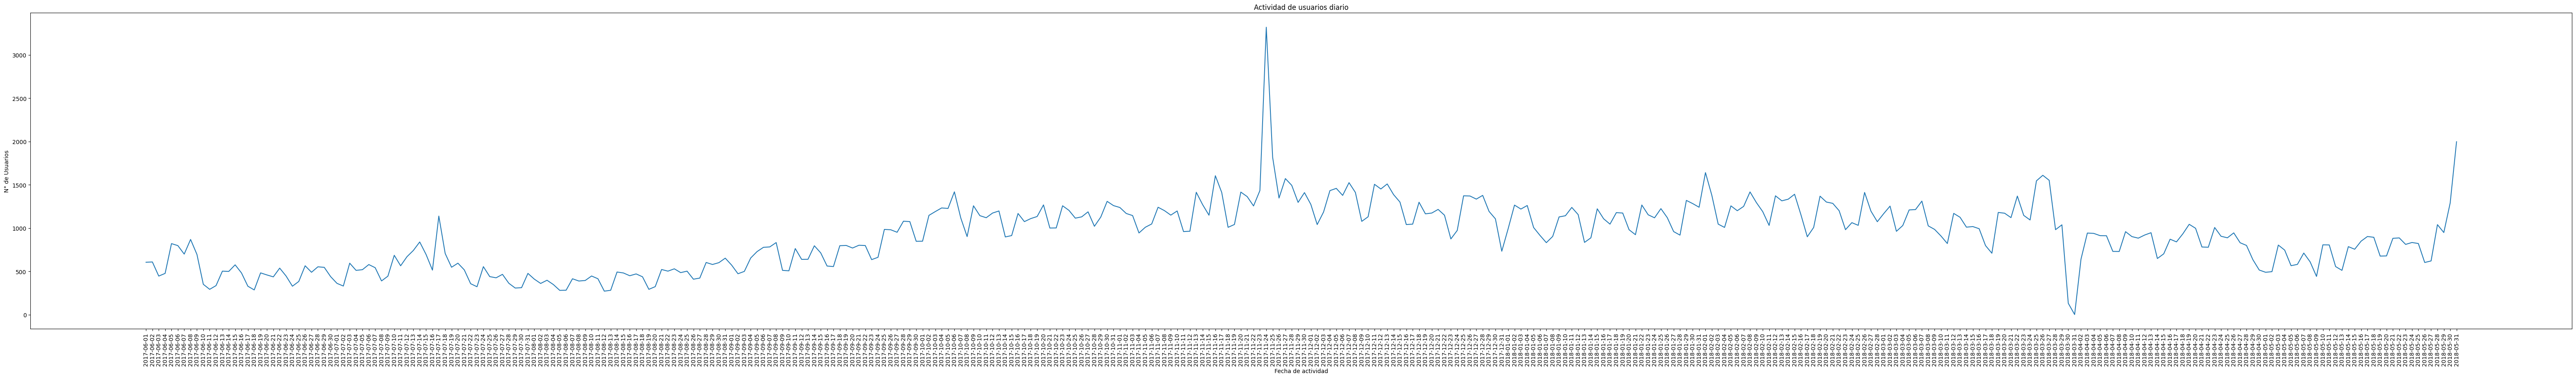

In [20]:
# Indicador de DAU
#print(sessions_per_day.head(5))
print('# Promedio de personas que usan la app por día:', sessions_per_day['n_users'].mean())

size = plt.subplots(figsize=(80, 10))
fig = sns.lineplot(data=sessions_per_day, x="session_date", y="n_users")
plt.xticks(rotation=90)
fig.set(xlabel ="Fecha de actividad", ylabel = "N° de Usuarios", title ='Actividad de usuarios diario');


Se observa que el número de usuarios activos por día es de 908 usuarios. Adicionalmente, se observa que hubo dos eventos atípicos, uno entre noviembre del 2017 y enero del 20218, y el segundo posterior a mayo del 2018. Se debe tener en cuenta para análisis posteriores si se deben excluir ya que podría llevarnos a conclusiones erradas.

   session_week  n_users  n_sessions
0        201722     2021        2309
1        201723     4129        4931
2        201724     2812        3214
3        201725     2878        3273
4        201726     3064        3514
5        201727     3294        3822
6        201728     4355        5105
7        201729     3841        4574
8        201730     2655        3072
9        201731     2364        2729
# Promedio de personas que usan la app por semana: 5716.245283018868


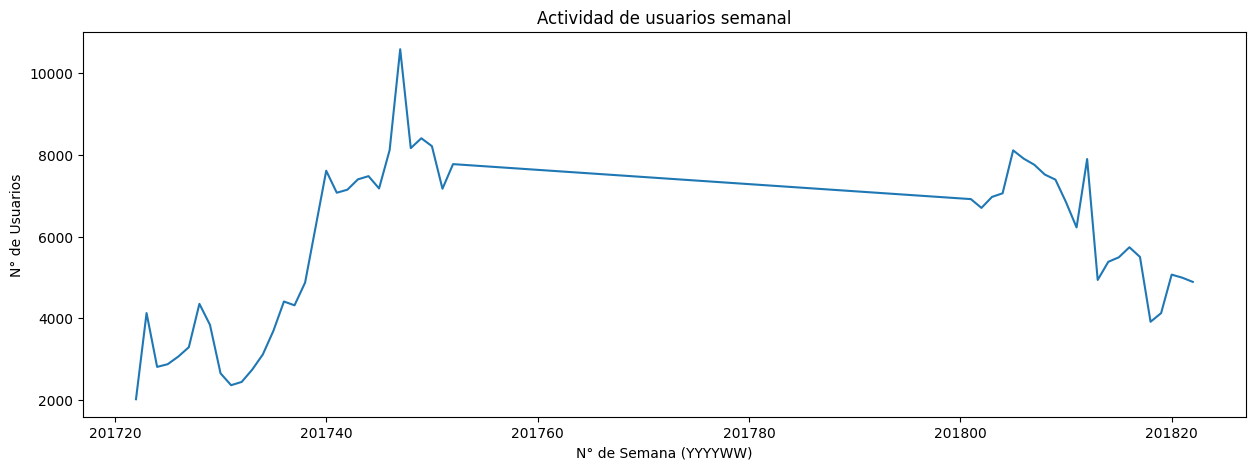

In [21]:
# Indicador WAU
print(sessions_per_week.head(10))
print('# Promedio de personas que usan la app por semana:', sessions_per_week['n_users'].mean())

size = plt.subplots(figsize=(15, 5))
fig = sns.lineplot(data=sessions_per_week, x="session_week", y="n_users")
fig.set(xlabel ="N° de Semana (YYYYWW)", ylabel = "N° de Usuarios", title ='Actividad de usuarios semanal');

Se observa que en promedio el número de usuarios activos por semana es de 5,716 usuarios.

# Promedio de personas que usan la app por mes: 23228.416666666668


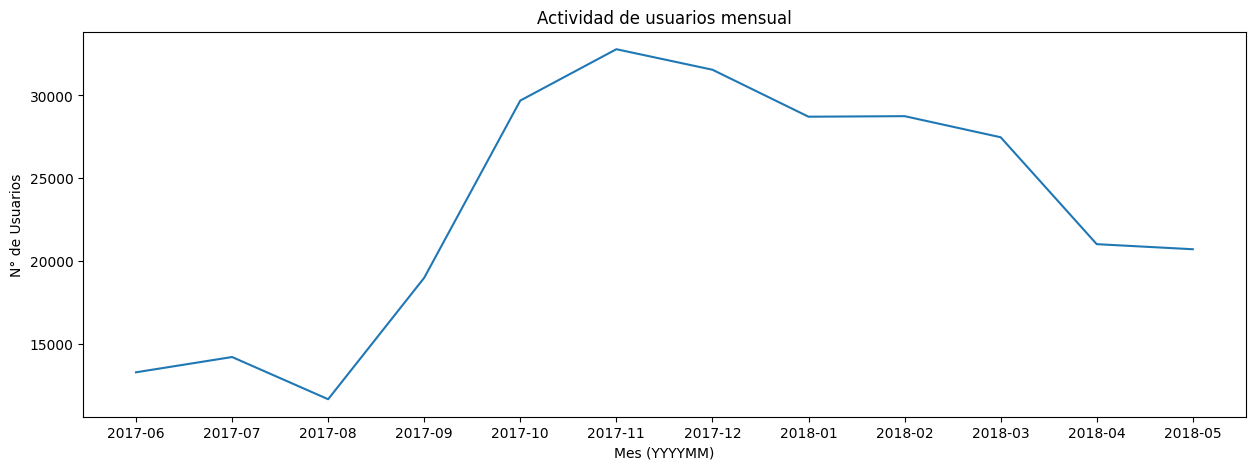

In [22]:
# Indicador MAU
#print(sessions_per_month.head(5))
print('# Promedio de personas que usan la app por mes:', sessions_per_month['n_users'].mean())

size = plt.subplots(figsize=(15, 5))
fig = sns.lineplot(data=sessions_per_month, x="session_month", y="n_users")
fig.set(xlabel ="Mes (YYYYMM)", ylabel = "N° de Usuarios", title ='Actividad de usuarios mensual');

Se observa que en promedio el número de usuarios activos por mes es de 23,228 usuarios.

#### ¿Cuántas sesiones hay por día? (Un/a usuario/a puede tener más de una sesión)

# Promedio de sesiones por día: 987.3626373626373


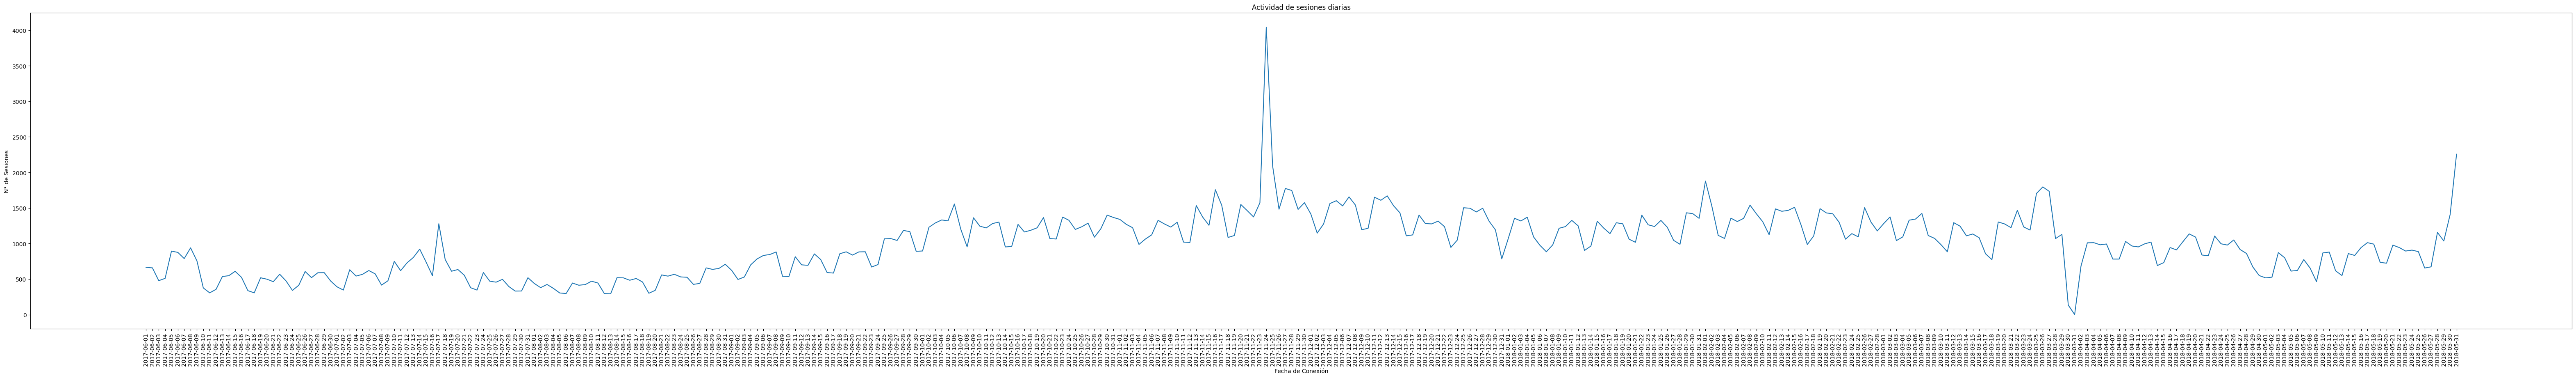

In [23]:
print('# Promedio de sesiones por día:', sessions_per_day['n_sessions'].mean())

size = plt.subplots(figsize=(80, 10))
plt.xticks(rotation=90)
fig = sns.lineplot(data=sessions_per_day, x="session_date", y="n_sessions")
fig.set(xlabel ="Fecha de Conexión", ylabel = "N° de Sesiones", title ='Actividad de sesiones diarias');

Se observa que el número de sesiones activas por día es de 987 sesiones. Adicionalmente, se observa que hubo dos eventos atípicos, uno entre noviembre del 2017 y enero del 20218, y el segundo posterior a mayo del 2018 (mismos que se observaron cuando analizamos la actividad de usuarios por día). Se debe tener en cuenta para análisis posteriores si se deben excluir ya que podría llevarnos a conclusiones erradas.

#### ¿Cuál es la duración de cada sesión?

Duración promedio de las sesiones de los usuarios:  643.506488592098
Moda de las sesiones de los usuarios:  0    60
dtype: int64


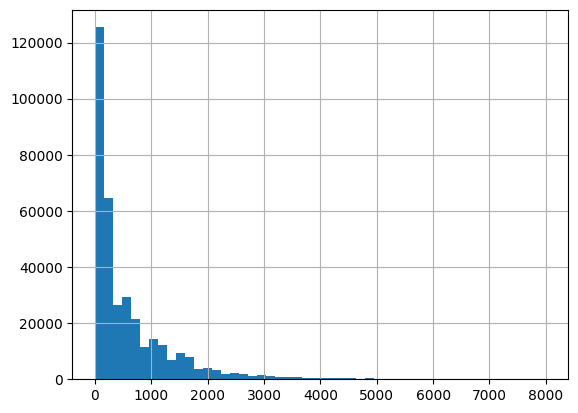

In [24]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

print('Duración promedio de las sesiones de los usuarios: ', visits['session_duration_sec'].mean())

visits['session_duration_sec'].hist(bins=50, range = (0,8000))

print('Moda de las sesiones de los usuarios: ', visits['session_duration_sec'].mode())

Dado que la distribución de la duración de conexión de los usuarios es asimétrica a la derecha, no se puede considerar la media de los datos sino la moda; es decir, consideraremos los valores que aparecen con mayor frecuencia. Este valor nos indica que la duración de una sesión se encuentra en 60 segundos (1 minuto).

#### ¿Con qué frecuencia los usuarios y las usuarias regresan?

In [25]:
# Para identificar la frecuencia en que regresan los usuarios nos sirve calcular la métrica de factor de adherencia (sticky factor)
sticky_wau = sessions_per_day['n_users'].mean()/sessions_per_week['n_users'].mean()*100
sticky_mau = sessions_per_day['n_users'].mean()/sessions_per_month['n_users'].mean()*100

print('La actividad semanal tiene como factor de adherencia semanal ', sticky_wau)
print('La actividad mensual tiene como factor de adherencia mensual', sticky_mau)

La actividad semanal tiene como factor de adherencia semanal  15.88440861589881
La actividad mensual tiene como factor de adherencia mensual 3.908969652437603


In [ ]:
# Para completar el ejercicio, de identificar con qué frecuencia regresan los usuarios a la app, calcularemos el ratio de retención

# Creamos el dataframe "first_visits" para tener las fechas de primera visita de cada usuario
first_visits = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
#first_visits.columns = ['uid', 'first_visit_date']

# Fecha del primer mes de visita de un usuario
first_visits['first_visit_month'] = first_visits['start_ts'].dt.to_period('M').dt.start_time

# Fecha Mes de cada visita de un usuario
visits['visit_month'] = visits['start_ts'].dt.to_period('M').dt.start_time

# Creamos el dataframe que contendrá las fechas de visita de cada usuario a la app asi como la fecha de su primera visita
visits_full = visits.merge(first_visits, on='uid', how='inner')

# Calculamos cuantos mes pasan entre cada visita de un usuario vs su primera visita
# visits_full['age_months'] = visits_full['visit_month']-visits_full['first_visit_month']

# visits_full['age_months'] = visits_full['age_months'] / np.timedelta64(1, 'M')
# visits_full['age_months'] = visits_full['age_months'].astype(int)


visits_full['age_months'] = ((visits_full['visit_month'] - visits_full['first_visit_month']).dt.days / 30.44).round().astype(int)


cohorts = visits_full.pivot_table(index='first_visit_month',
                  columns='age_months',
                  values='uid',
                  aggfunc='nunique')

retention = pd.DataFrame()

for col in cohorts.columns:
    retention = pd.concat([retention, cohorts[col]/cohorts[0]], axis=1)
retention.columns = cohorts.columns
retention.index = [str(x)[0:10] for x in retention.index]

print(retention)



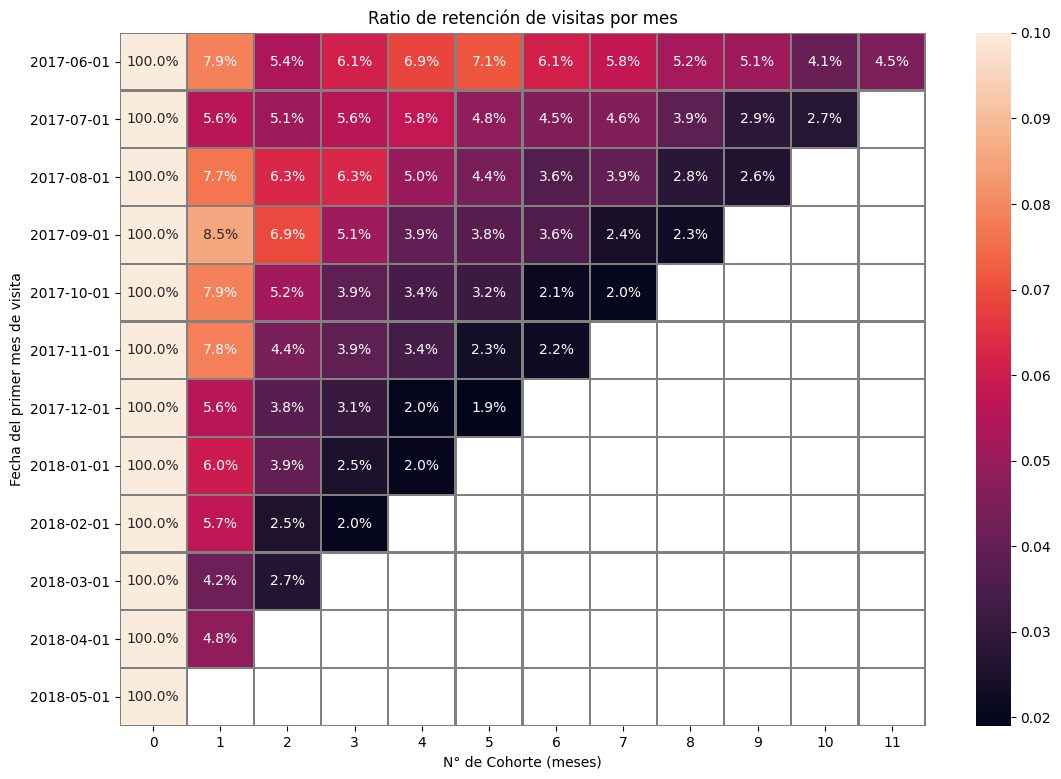

In [28]:
#Graficamos
plt.figure(figsize=(13, 9))

fig = sns.heatmap(
    retention,
    annot=True,
    fmt='.1%',
    vmax = .1,
    linewidths=1,
    linecolor='gray'
)

fig.set(xlabel ='N° de Cohorte (meses)', ylabel = "Fecha del primer mes de visita", title ='Ratio de retención de visitas por mes');

### Ventas

#### ¿Cuándo la gente empieza a comprar?
(En el análisis de KPI, generalmente nos interesa saber el tiempo que transcurre entre el registro y la conversión, es decir, cuando el/la usuario/a se convierte en cliente. Por ejemplo, si el registro y la primera compra ocurren el mismo día, el/la usuario/a podría caer en la categoría Conversion 0d. Si la primera compra ocurre al día siguiente, será Conversion 1d. Puedes usar cualquier enfoque que te permita comparar las conversiones de diferentes cohortes para que puedas determinar qué cohorte o canal de marketing es más efectivo).

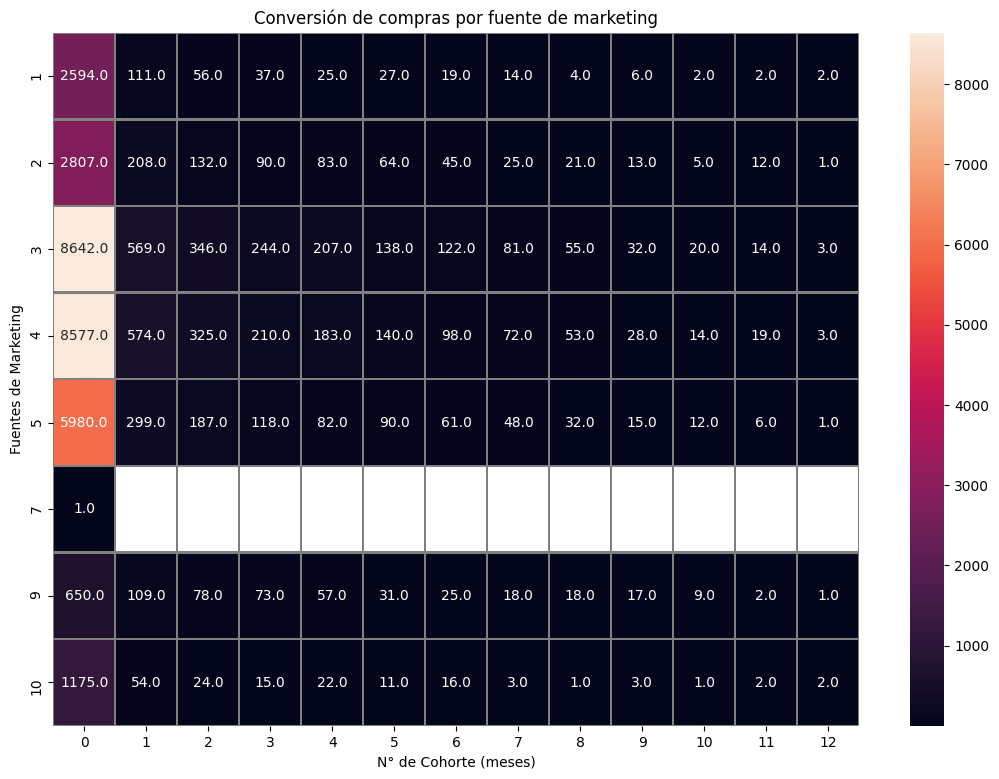

In [27]:
# creamos dos dataframes donde obtendremos la primera fecha de visita y fecha de orden de cada usuario
cohorts_visits = visits.groupby('uid')['start_ts'].min().reset_index()
cohorts_orders = orders.groupby('uid')['buy_ts'].min().reset_index()

# renombramos las columnas de los dataframes agrupados
cohorts_visits.columns = ['uid', 'first_visit_date']
cohorts_orders.columns = ['uid', 'first_order_date']

#print(visits[visits['uid']==17746289217806626778][['uid','source_id','start_ts']])
#print(visits['uid'].value_counts().head(10000))

visits_aux = visits[['uid', 'source_id', 'start_ts']]
visits_aux.columns = ['uid','source_id', 'first_visit_date']

cohorts_visits = cohorts_visits.merge(visits_aux, on=['uid','first_visit_date'], how='inner')
#print(cohorts_visits[cohorts_visits['uid']==17746289217806626778])

# combinamos los dos dataframes "first_visit_date_per_user" y "first_order_date_per_user" usando como llave el campo "uid"
cohorts_visits = cohorts_visits.merge(cohorts_orders, on='uid')
#print(cohorts_visits)

# creamos la columna "first_visit_date" y "first_order_date"
cohorts_visits['first_visit_date'] = cohorts_visits['first_visit_date'].astype(
    'datetime64[D]')
cohorts_visits['first_order_date'] = cohorts_visits['first_order_date'].astype(
    'datetime64[D]')

cohorts_visits['cohort_lifetime'] = cohorts_visits['first_order_date']-cohorts_visits['first_visit_date']
#print(cohorts_visits.head())
cohorts_visits['cohort_lifetime'] = cohorts_visits['cohort_lifetime'] / np.timedelta64(1, 'M')
#print(cohorts_visits.head())
cohorts_visits['cohort_lifetime'] = cohorts_visits['cohort_lifetime'].round().astype('int')
cohorts_visits['first_order_date'] = cohorts_visits['first_order_date'].dt.strftime('%Y.%m.%d')
cohorts_visits['first_visit_date'] = cohorts_visits['first_visit_date'].dt.strftime('%Y.%m.%d')

#print(cohorts_visits.head())

cohorts_visits_pivot = cohorts_visits.pivot_table(
    index='source_id',
    columns='cohort_lifetime',
    values='uid',
    aggfunc='count',
)

#Graficamos

plt.figure(figsize=(13, 9))

fig = sns.heatmap(
    cohorts_visits_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray'
)

fig.set(xlabel ='N° de Cohorte (meses)', ylabel = "Fuentes de Marketing", title ='Conversión de compras por fuente de marketing');

Se observa que hay mayor efectividad de que un cliente concrete una compra por los canales de marketing 3 y 4. También se observa que el canal de marketing con menos efectividad es el 7.
Si vemos los cohortes, se observa que gran parte de los visitantes realizan su primera compra dentro el 1 primer mes.

#### ¿Cuántos pedidos hacen durante un período de tiempo dado?

Cantidad de pedidos que realizaron los clientes en el primer cohorte es de  37.26724389880543


cohort_lifetime
0     14.627238
1     34.723297
2     51.059129
3     63.190459
4     71.682060
5     76.836866
6     79.238353
7     78.346215
8     75.691748
9     67.459247
10    53.548809
11    37.267244
dtype: float64

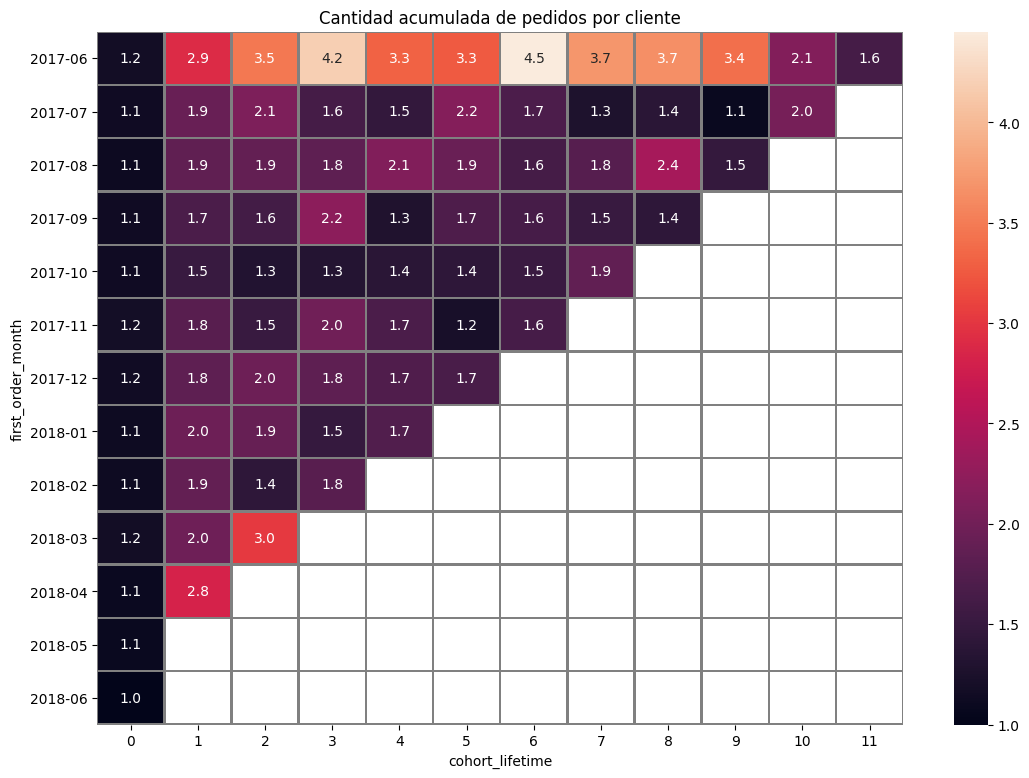

In [28]:

first_order_date_by_customers = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
orders = orders.join(first_order_date_by_customers, on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

orders_grouped_by_cohorts = orders.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum', 'uid': ['nunique','count']}).reset_index()
orders_grouped_by_cohorts.columns = ['first_order_month','order_month','revenue','n_buyers','n_orders']

orders_grouped_by_cohorts['n_orders_per_buyers'] = orders_grouped_by_cohorts['n_orders']/orders_grouped_by_cohorts['n_buyers']

orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month'])
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime']/np.timedelta64(1, 'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
#print(orders_grouped_by_cohorts.head())

orders_per_user_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='n_orders_per_buyers',
    aggfunc='sum',
)
#print(orders_per_user_pivot)

plt.figure(figsize=(13, 9))
plt.title('Cantidad acumulada de pedidos por cliente')
sns.heatmap(
    orders_per_user_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
)

orders_201706 = orders_per_user_pivot.loc['2017-06'].sum()
print('Cantidad de pedidos que realizaron los clientes en el primer cohorte es de ', orders_201706)

orders_per_user_pivot.cumsum(axis=1).sum(axis=0)

Los clientes que realizaron su primera compra en junio de 2017 realizaron un promedio total de 37.3 pedidos por cliente durante su ciclo de vida de 12 meses. Adicionalmente, se observa que todos los clientes realizan compras en el primer mes.

#### ¿Cuál es el tamaño promedio de compra?

In [29]:
orders_grouped_by_cohorts

,first_order_month,order_month,revenue,n_buyers,n_orders,n_orders_per_buyers,cohort_lifetime
0,2017-06,2017-06-01,9557.49,2023,2354,1.163618,0
1,2017-06,2017-07-01,981.82,61,177,2.901639,1
2,2017-06,2017-08-01,885.34,50,174,3.480000,2
3,2017-06,2017-09-01,1931.30,54,226,4.185185,3
4,2017-06,2017-10-01,2068.58,88,292,3.318182,4
...,...,...,...,...,...,...,...
74,2018-03,2018-05-01,1114.87,58,176,3.034483,2
75,2018-04,2018-04-01,10600.69,2276,2495,1.096221,0
76,2018-04,2018-05-01,1209.92,69,195,2.826087,1
77,2018-05,2018-05-01,13925.76,2988,3249,1.087349,0


Los ingresos recaudados de los clientes del primer cohorte es de  24031.68999999999


cohort_lifetime
0     13629.574615
1     16162.882727
2     17816.574000
3     19971.226667
4     21244.330000
5     22765.992857
6     21827.781667
7     21600.110000
8     20675.387500
9     16597.076667
10    19819.995000
11    24031.690000
dtype: float64

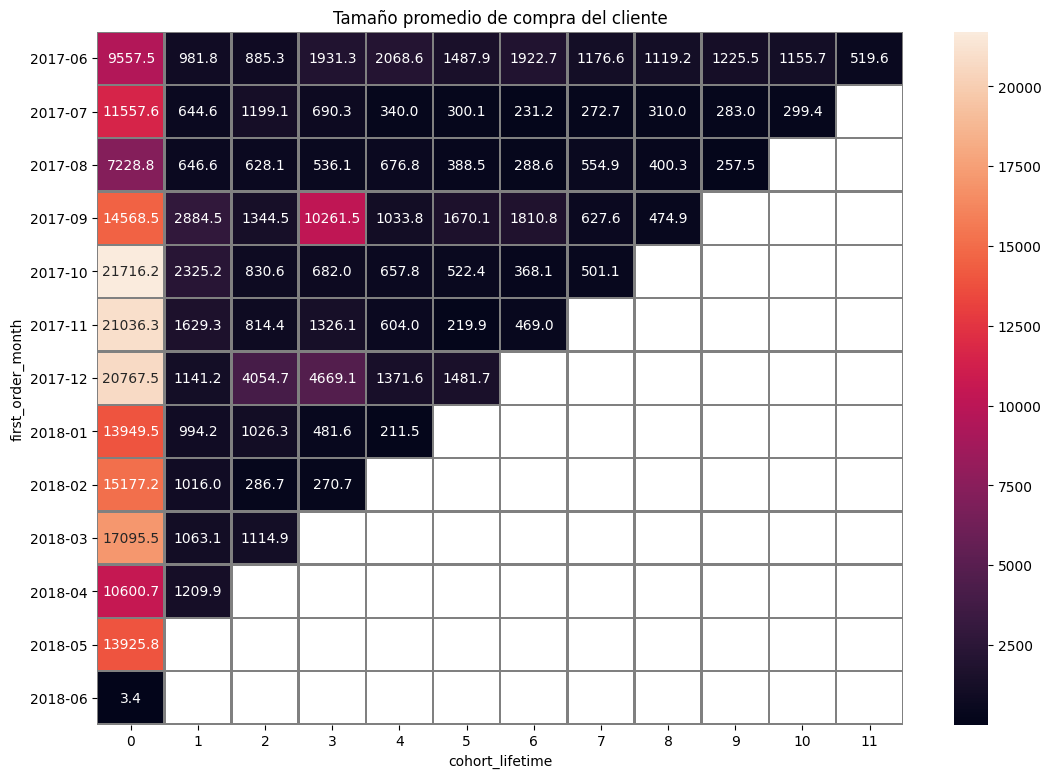

In [30]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue',
    aggfunc='mean',
)
#print(revenue_per_user_pivot)

plt.figure(figsize=(13, 9))
plt.title('Tamaño promedio de compra del cliente')
sns.heatmap(
    revenue_per_user_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
)

revenue_201706 = revenue_per_user_pivot.loc['2017-06'].sum()
print('Los ingresos recaudados de los clientes del primer cohorte es de ', revenue_201706)

revenue_per_user_pivot.cumsum(axis=1).mean(axis=0)

Se observa que los ingresos recaudados por los clientes se da en el primer mes del ciclo de vida del cliente. Adicionalmente, se observa que en setiembre 2017 en el cuarto mes del ciclo de vida del cliente se realizaron más compras de lo normal, podría deberse a que se lanzaron campañas. Lo mismo pasa con los clientes que realizaron su primera compra en diciembre 2017.

#### ¿Cuánto dinero traen? (LTV)

ltv =  102.0


cohort_lifetime
0       1.923077
1       6.818182
2      12.800000
3      25.000000
4      32.625000
5      40.857143
6      43.666667
7      53.800000
8      66.750000
9      58.333333
10     71.000000
11    102.000000
dtype: float64

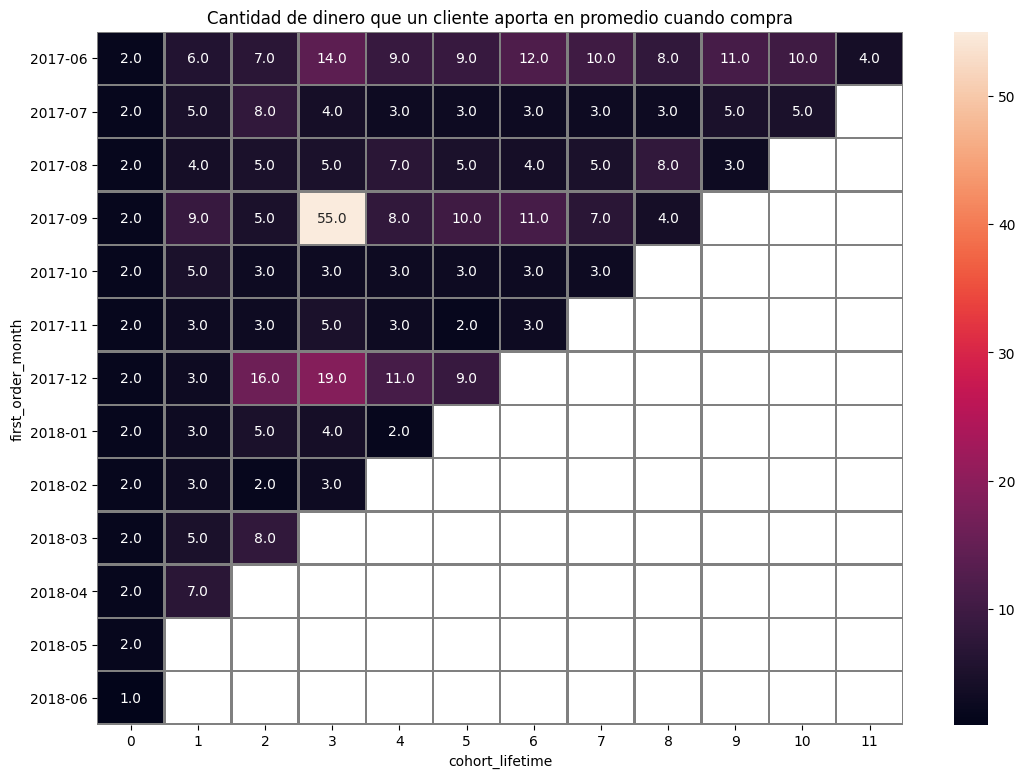

In [31]:
#Creamos un dataframe para hallar el indicador LTV
report = orders_grouped_by_cohorts

#Definimos un margen de beneficio (asumimos un 40%)
margin_rate = 0.4

#Calculamos la ganancia bruta
report['gp'] = report['revenue'] * margin_rate

#print(report.head())

#Calculamos la cantidad total de dinero que un cliente aporta a la empresa en promedio al realizar compras
report['ltv'] = report['gp']/report['n_buyers']

report_ltv = report.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='ltv',
    aggfunc='mean'
).round()

#Graficamos el dataframe ltv para tener un mejor entendimiento
plt.figure(figsize=(13, 9))
plt.title('Cantidad de dinero que un cliente aporta en promedio cuando compra')
sns.heatmap(
    report_ltv,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
)

ltv_201706 = report_ltv.loc['2017-06'].sum()
print('ltv = ',ltv_201706)

report_ltv.cumsum(axis=1).mean(axis=0)

En promedio, un cliente aporta $102 cuando compra durante 12 meses de su ciclo de vida.

### Marketing
Traza gráficos para mostrar cómo difieren estas métricas para varios dispositivos y fuentes de anuncios y cómo cambian con el tiempo.

#### ¿Cuánto dinero se gastó?
(Total/por fuente de adquisición/a lo largo del tiempo)

<AxesSubplot:title={'center':'Gastos por fuente de marketing'}, xlabel='cohort_lifetime', ylabel='source_id'>

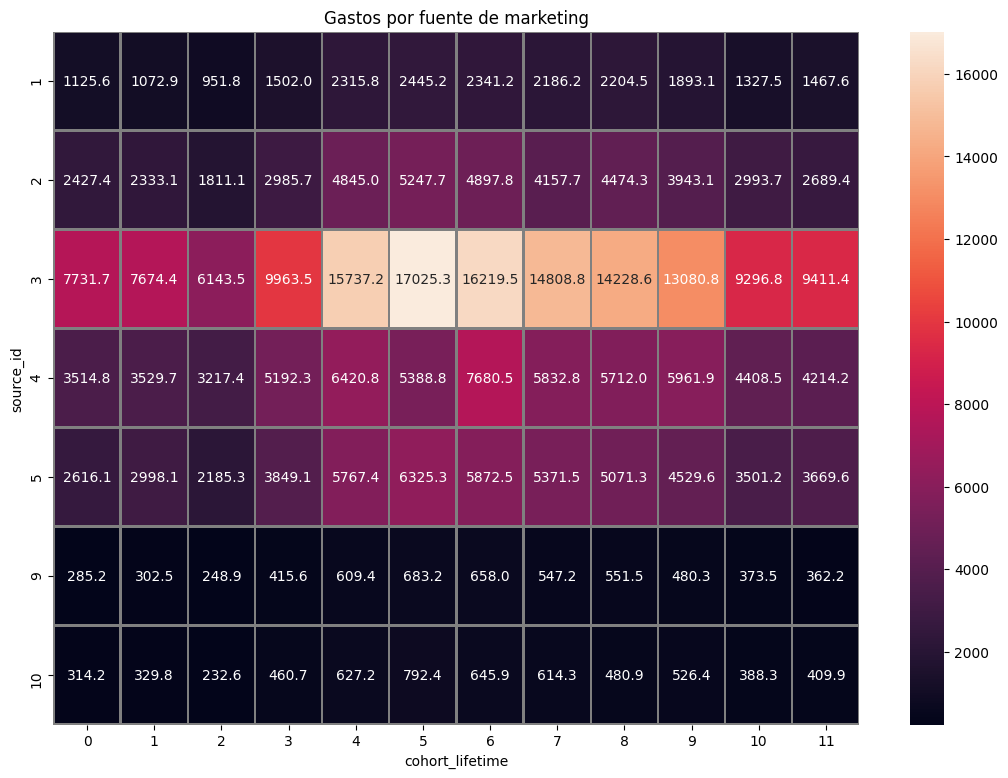

In [32]:
# Calculamos la primera fecha de compra por canal de marketing
first_cost_by_source = costs.groupby('source_id')['dt'].min()
first_cost_by_source.name = 'first_cost_date'
first_cost_by_source.columns = ['source_id','first_cost_date']

# Combinamos dataframes, para tener en uno solo el detalle del dataframe costs y la primera fecha de compra por canal de marketing
costs = costs.join(first_cost_by_source, on='source_id')
costs.columns = ['source_id','cost_date','costs','first_cost_date']

# Convertimos las columnas al tipo datetime para poder manipular los datos y definir los cohortes
costs['first_cost_month'] = costs['first_cost_date'].astype('datetime64[M]')
costs['cost_month'] = costs['cost_date'].astype('datetime64[M]')

# Creamos el dataframe de cohortes para poder calcular el ciclo de vida de cada cohorte 
costs_grouped_by_cohorts = costs.groupby(['source_id', 'cost_month','first_cost_month']).agg({'costs': 'sum'}).reset_index()
costs_grouped_by_cohorts.columns = ['source_id','cost_month','first_cost_month','costs']

#print(costs_grouped_by_cohorts.tail(50))

# Calculamos el cohort_lifetime
costs_grouped_by_cohorts['cohort_lifetime'] = (costs_grouped_by_cohorts['cost_month'] - costs_grouped_by_cohorts['first_cost_month'])
costs_grouped_by_cohorts['cohort_lifetime'] = costs_grouped_by_cohorts['cohort_lifetime']/np.timedelta64(1, 'M')
costs_grouped_by_cohorts['cohort_lifetime'] = costs_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
costs_grouped_by_cohorts['first_cost_month'] = costs_grouped_by_cohorts['first_cost_month'].dt.strftime('%Y-%m')
#print(costs_grouped_by_cohorts.tail())

#Definimos la tabla de gasto total por cohorte y fuente de marketing
costs_per_device_pivot = costs_grouped_by_cohorts.pivot_table(
    index='source_id',
    columns='cohort_lifetime',
    values='costs',
    aggfunc='sum',
)
#print(costs_per_device_pivot)

#Graficamos
plt.figure(figsize=(13, 9))
plt.title('Gastos por fuente de marketing')
sns.heatmap(
    costs_per_device_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
)

In [33]:
# Calculando el costo total y por fuente de canal de marketing
print('Gasto total de marketing: ', costs_grouped_by_cohorts['costs'].sum())

print('Gasto por canal de marketing: ')
print(costs_grouped_by_cohorts.groupby('source_id')['costs'].sum().reset_index().sort_values(by='costs'))

Gasto total de marketing:  329131.62
Gasto por canal de marketing: 
   source_id      costs
5          9    5517.49
6         10    5822.49
0          1   20833.27
1          2   42806.04
4          5   51757.10
3          4   61073.60
2          3  141321.63


#### ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

cohort_lifetime
0       1.306765
1      39.363954
2      91.916752
3     156.203579
4     223.794639
5     295.106411
6     364.619072
7     432.844948
8     507.490360
9     588.755372
10    667.462121
11    716.020073
dtype: float64

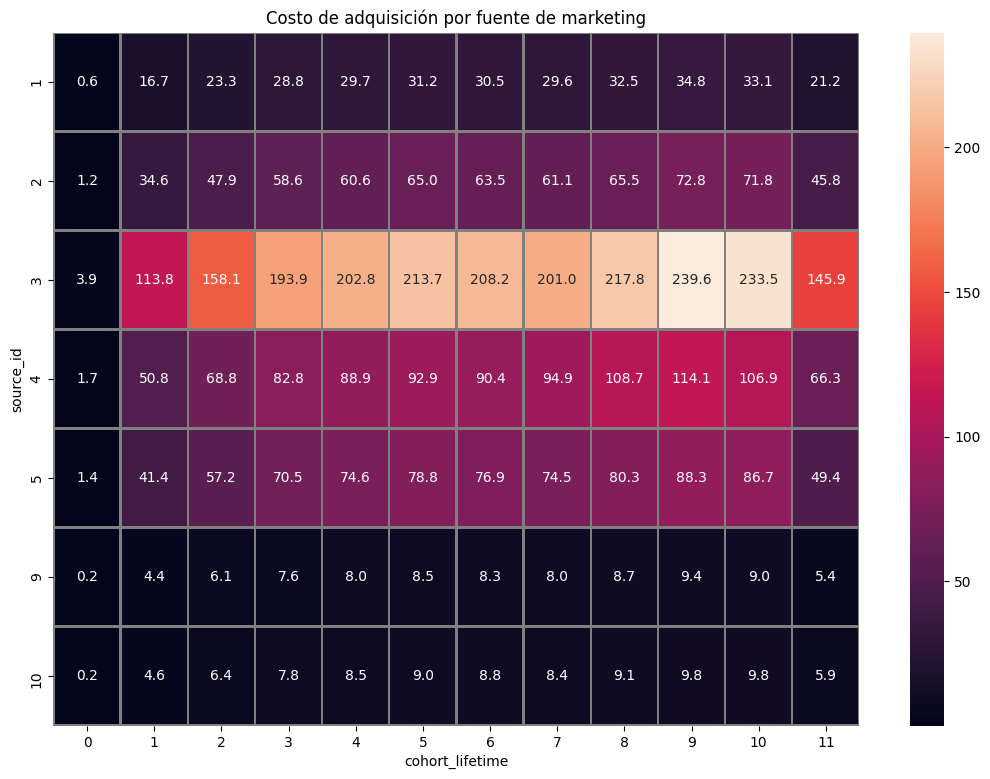

In [34]:
# Convertimos el campo "first_order_month" a datetime para poder manipular los datos
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')

# Creamos un dataframe de gastos de marketing por fecha
#monthly_costs = costs.groupby('cost_month')['costs'].sum()
costs_grouped_by_cohorts = costs_grouped_by_cohorts.drop(columns=['cohort_lifetime'])

#Agregamos el campo de gastos de marketing al dataframe report que contiene los ratios de ltv y gp
report_ = pd.merge(
    report, costs_grouped_by_cohorts, left_on='first_order_month', right_on='cost_month'
)

report_['first_order_month'] = report_['first_order_month'].dt.strftime('%Y-%m')

#print(report_.head(5))

# Calculamos el ratio de CAC
report_['cac'] = report_['costs'] / report_['n_buyers']

# Creamos un pivot table con la información de costo de adquisición por fuente de marketing
cac_per_device_pivot = report_.pivot_table(
    index='source_id',
    columns='cohort_lifetime',
    values='cac',
    aggfunc='mean',
)

# Graficamos
plt.figure(figsize=(13, 9))
plt.title('Costo de adquisición por fuente de marketing')
sns.heatmap(
    cac_per_device_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
)

cac_per_device_pivot.cumsum(axis=1).mean(axis=0)

#### ¿Cuán rentables eran las inversiones? (ROMI)

<AxesSubplot:title={'center':'Retorno de inversión por fuente de marketing'}, xlabel='cohort_lifetime', ylabel='source_id'>

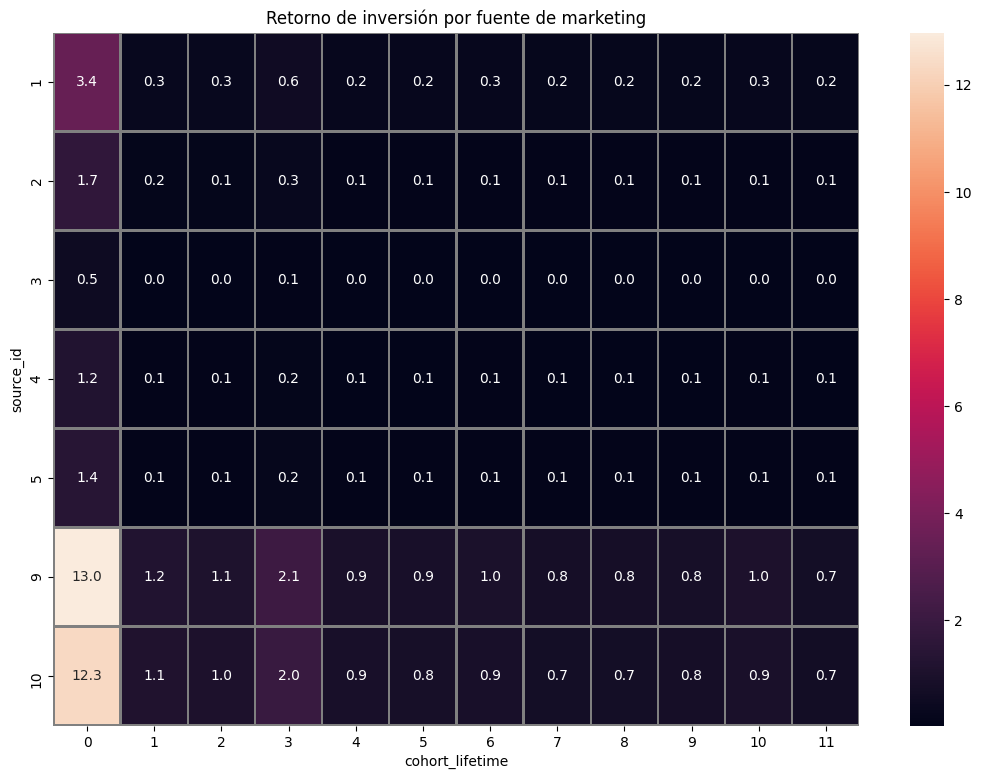

In [35]:
# Calculando el ROMI
report_['romi'] = report_['ltv'] / report_['cac']
#print(report_.head(5))

# Creamos un pivot table con la información de ROMI por fuente de marketing
romi_per_device_pivot = report_.pivot_table(
    index='source_id',
    columns='cohort_lifetime',
    values='romi',
    aggfunc='mean'
)

# Graficamos
plt.figure(figsize=(13, 9))
plt.title('Retorno de inversión por fuente de marketing')
sns.heatmap(
    romi_per_device_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
)

cohort_lifetime
0      4.778627
1      5.147320
2      5.580723
3      6.334936
4      6.857961
5      7.534272
6      7.841319
7      8.579357
8      9.323424
9      8.686000
10     9.793043
11    12.063933
dtype: float64

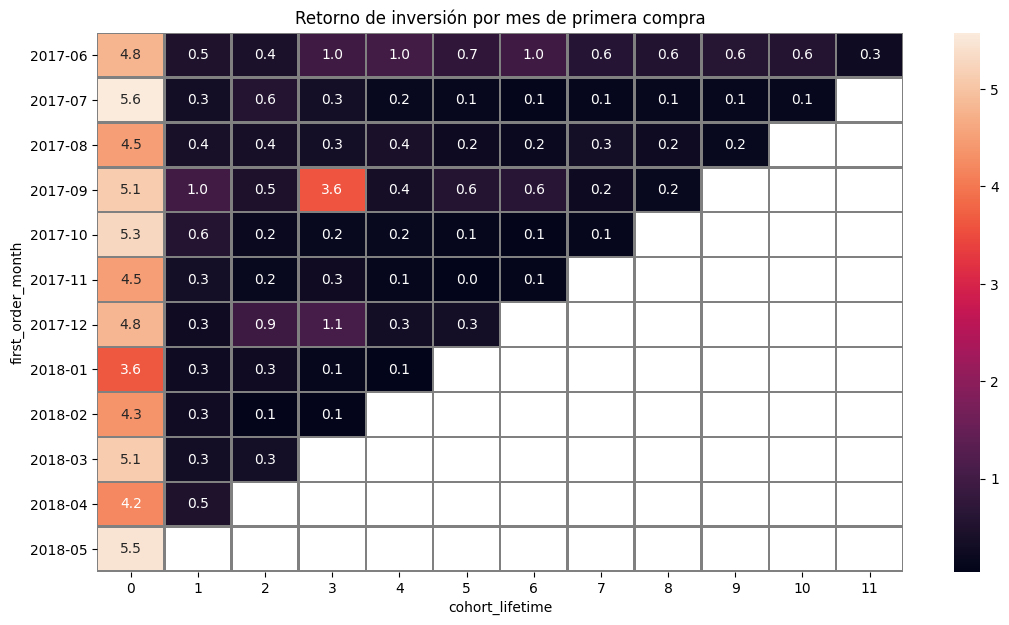

In [36]:
# Creamos un pivot table con la información de ROMI por mes de primera compra
romi_per_order_pivot = report_.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='romi',
    aggfunc='mean'
)

# Graficamos
plt.figure(figsize=(13, 7))
plt.title('Retorno de inversión por mes de primera compra')
sns.heatmap(
    romi_per_order_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
)

romi_per_order_pivot.cumsum(axis=1).mean(axis=0)

## Conclusión
Aconseja a los expertos de marketing cuánto dinero invertir y dónde ¿Qué fuentes/plataformas recomendarías? Fundamenta tu selección: ¿en qué métricas te enfocaste? ¿Por qué? ¿Qué conclusiones sacaste después de encontrar los valores métricos?

Luego de evaluar la actividad de los usuarios y definir métricas para evaluar la rentabilidad del negocio, se concluye lo siguiente:
* En la evaluación de la actividad de los usuarios, se observo que la adherencia semanal (15.8) y mensual (3.9) es muy buena, por lo que esta aplicación es muy atractiva para capturar nuevos inversores.
* Los usuarios suelen estar activos por lo menos 1 minuto en la aplicación, por lo que se sugeriría que los anuncios y ofertas para incentivar a que el cliente realice una compra se realice dentro de ese tiempo.
* La conversión de compra de los clientes se da en el primer mes de actividad de los usuarios; sin embargo, luego empieza a decrecer, para poder mantener la conversión de compra se tendría que invertir en conseguir nuevos clientes.
* Respecto a los indicadores de economía, el indicador ROMI nos indica que las plataformas con mejor retorno de inversión son la 9 y 10, por ello recomendaría al equipo de marketing que prioricen invertir en esos canales.
* Por otro lado, el indicador ROMI también nos indica que hay que evaluar si se continúa invirtiendo en el canal de marketing 3 porque no se está recuperando la inversión, los gastos estan siendo mayores por este canal pero no se materializa un beneficio para la empresa en ningún mes. Por otro lado, los canales de marketing 1, 2, 4 y 5 si bien generan un retorno de inversión en el primer mes luego este deja de generar beneficios a la empresa, aquí se sugiere profundizar más para ver si es necesario seguir gastando lo mismo o reducir el presupuesto.
* Si vemos el ROMI por cohorte, se observa que en el primer mes el retorno de inversión es excelente para la empresa; sin embargo, luego la empresa deja de tener ganancias (salvo excepciones puntuales en algunos meses) y empieza a perder conforme avanzan los meses. Esto guarda relación con la métrica de conversión de compra, sería genial hacer encuestas para indagar por qué deja de ser atractiva la aplicación luego de la primer mes de interacción en la aplicación.